## Single label, Multi-class classification

Finetune a pretrained ResNeXt101 CNN to identify dog images into their correct class.   
Images were taken form [Kaggle Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification/data), where there are 120 different classes of dogs.

#### Load libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

#### Set image directory

In [3]:
PATH = Path('data/DogBreed')

In [4]:
labelpath = PATH/"labels.csv"

Select 20% of them for cross validation.

In [5]:
le = len(list(open(labelpath)));le

10223

In [6]:
val_idxs = get_cv_idxs(le-1)

Take a peek at the label.csv

In [14]:
label_df = pd.read_csv(labelpath)
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [16]:
classes = label_df.breed.value_counts(); classes[:10]

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
pomeranian              111
great_pyrenees          111
basenji                 110
samoyed                 109
Name: breed, dtype: int64

In [17]:
len(classes)

120

#### Build Model

In [7]:
arch = resnext101_64
bs = 64
sz = 224

In [8]:
tfms = tfms_from_model(arch,sz,aug_tfms = transforms_side_on , max_zoom = 1.1)

In [9]:
data = ImageClassifierData.from_csv(PATH, 'train', 
                                    labelpath,test_name = 'test',
                                    val_idxs = val_idxs,tfms = tfms,bs = bs,suffix = '.jpg',)

#### Training Images

In [37]:
xs,_ = next(iter(data.trn_dl))
xs = xs[:16]

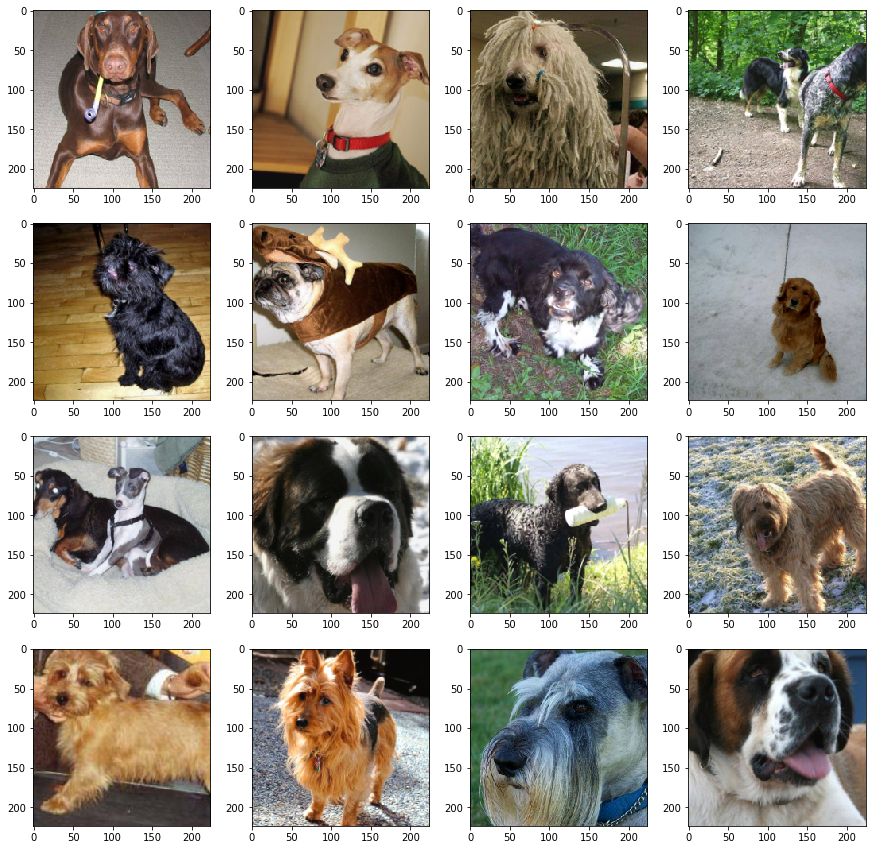

In [40]:
_ , ax = plt.subplots(4,4, figsize = (15,15))

for i,img in enumerate(xs):    
    axe = ax.flat[i]
    img = data.trn_ds.denorm(to_np(img)).squeeze()
    axe.imshow(img)

 #### Check image sizes

In [25]:
size_d = {i:PIL.Image.open(PATH/i).size for i in data.trn_ds.fnames}

In [26]:
row_sz,col_sz  = list(zip(*size_d.values()))    

In [27]:
row_sz = np.array(row_sz ) ; col_sz =  np.array(col_sz)

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

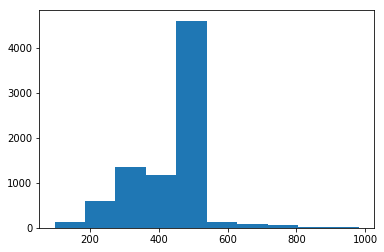

In [28]:
plt.hist(row_sz[row_sz<1000])

(array([ 235.,  733., 2205., 2979., 1807.,   98.,   27.,   33.,    7.,   10.]),
 array([102., 190., 278., 366., 454., 542., 630., 718., 806., 894., 982.]),
 <a list of 10 Patch objects>)

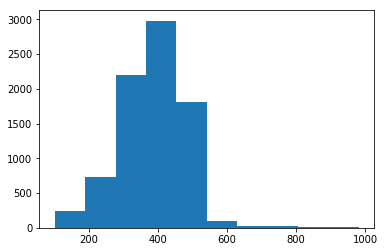

In [29]:
plt.hist(col_sz[col_sz<1000])

In [30]:
len(data.trn_ds),len(data.test_ds)

(8178, 10357)

In [31]:
data.classes[:10]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle']

#### Precompute = True (Train Final Layer)

In [10]:
learn = ConvLearner.pretrained(arch,data=data,precompute=True)

In [33]:
learn.lr_find()

 95%|█████████▍| 121/128 [00:23<00:01,  5.10it/s, loss=5.93]

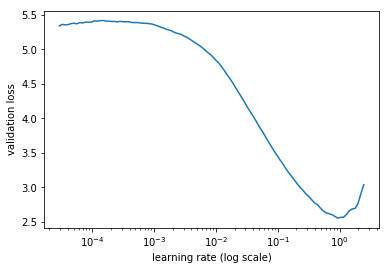

In [34]:
learn.sched.plot()

In [52]:
lr = 1e-1

In [53]:
learn.fit(lr,3)

epoch      trn_loss   val_loss   accuracy                    
    0      0.674101   0.369286   0.89726   
    1      0.36008    0.277282   0.90998                     
    2      0.25069    0.279974   0.91683                     


[array([0.27997]), 0.9168297457135121]

#### Precompute = False (Data augmentation activated)

In [11]:
learn.precompute =False

In [64]:
learn.fit(lr,1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.304333   0.277255   0.914384  


[array([0.27726]), 0.9143835612939062]

#### Unfreeze (Train all layers)

In [12]:
learn.unfreeze()

In [24]:
data.bs = 32

In [25]:
learn.lr_find()

 95%|█████████▌| 122/128 [01:15<00:03,  1.61it/s, loss=9.19]

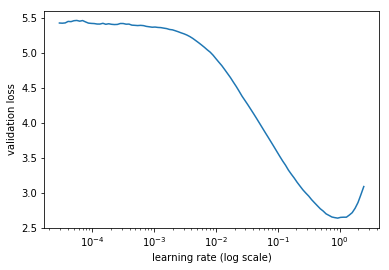

In [26]:
learn.sched.plot()

In [27]:
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])

In [28]:
learn.fit(lrs, 3, cycle_len= 1,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.375097   0.704742   0.884051  
    1      0.669937   0.34011    0.918787                    
    2      0.485039   0.313429   0.922211                    
    3      0.421025   0.270396   0.922701                    
    4      0.349726   0.25306    0.924168                    
    5      0.299568   0.243655   0.92319                     
    6      0.289448   0.240853   0.928082                    


[array([0.24085]), 0.92808219096432]

In [14]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom = 1.1)
    data = ImageClassifierData.from_csv(path = PATH,
                             folder = 'train',
                             csv_fname = labelpath,
                             bs = bs,
                             tfms = tfms,
                             val_idxs = val_idxs,
                             suffix = '.jpg',
                             test_name = 'test',
                             skip_header=True,
                             num_workers= 4,  
                             cat_separator=' ',
                            )
    return data if sz>300 else data.resize(340,'tmp')
    

#### Increase Image size to 299

Increasing image size from 224 to 299 allows us to train longer yet avoid overfitting. 

In [15]:
learn.set_data(get_data(299,16))
learn.freeze() # Remember to freeze again, new size might destroy early weights if 
               # final layer not accustomed to new size (?)

In [34]:
learn.lr_find()

 88%|████████▊ | 113/128 [02:10<00:17,  1.15s/it, loss=1.09] 

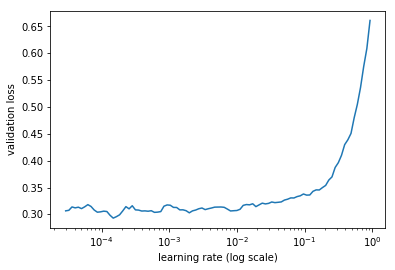

In [35]:
learn.sched.plot()

In [38]:
lr = 1e-3

In [37]:
learn.fit(lr,3)

epoch      trn_loss   val_loss   accuracy                    
    0      0.310537   0.25695    0.920254  
    1      0.291929   0.251645   0.922701                    
    2      0.291522   0.249602   0.924658                    


[array([0.2496]), 0.9246575347131479]

#### Unfreeze

In [11]:
learn.unfreeze()

In [ ]:
lr = 1e-3
lrs = np.array([lr/100,lr/10,lr])

In [42]:
learn.fit(lrs,2,cycle_len=2,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.372142   0.243908   0.922701  
    1      0.379787   0.247465   0.925147                    
    2      0.350471   0.243432   0.920254                    
    3      0.384493   0.236077   0.922211                    
    4      0.33788    0.233111   0.925636                    
    5      0.297104   0.234342   0.921722                    



[array([0.23434]), 0.9217221135029354]

In [44]:
learn.fit(lrs,1,cycle_len=4)

epoch      trn_loss   val_loss   accuracy                    
    0      0.284018   0.22867    0.922701  
    1      0.292609   0.231576   0.923679                    
    2      0.254964   0.22767    0.924658                    
    3      0.296466   0.231606   0.924168                    



[array([0.23161]), 0.9241682974559687]

#### Use all data (Train + Valid) to train 

(val_idxs = None)

In [53]:
data = ImageClassifierData.from_csv(path = PATH,
                             folder = 'train',
                             csv_fname = labelpath,
                             bs = bs,
                             tfms = tfms,
                             val_idxs = None,
                             suffix = '.jpg',
                             test_name = 'test',
                             skip_header=True,
                             num_workers= 4,  
                             cat_separator=' ',
                            )

In [54]:
learn.set_data(data)

In [75]:
learn.fit(lrs,1,cycle_len=4)

epoch      trn_loss   val_loss   accuracy                    
    0      0.293795   0.221001   0.927593  
    1      0.246731   0.225107   0.92955                     
    2      0.254915   0.220289   0.928571                    
    3      0.225169   0.218964   0.930528                    


[array([0.21896]), 0.9305283757338552]

In [77]:
learn.fit(lrs,1,cycle_len=4)

epoch      trn_loss   val_loss   accuracy                    
    0      0.242186   0.230748   0.929061  
    1      0.26289    0.222912   0.928082                    
    2      0.221652   0.222079   0.928571                    
    3      0.240557   0.22251    0.930039                    


[array([0.22251]), 0.9300391389432485]

In [108]:
learn.fit(lrs,1,cycle_len=4)

epoch      trn_loss   val_loss   accuracy                    
    0      0.235923   0.21993    0.928571  
    1      0.207445   0.222338   0.925636                    
    2      0.197718   0.213164   0.933464                    
    3      0.256315   0.221245   0.930528                    


[array([0.22124]), 0.9305283757338552]

In [96]:
learn.fit(lrs,1,cycle_len=4)

epoch      trn_loss   val_loss   accuracy                    
    0      0.24167    0.221257   0.924168  
    1      0.29154    0.222527   0.931507                    
    2      0.233843   0.219404   0.926614                    
    3      0.192587   0.212348   0.932975                    
    4      0.198926   0.218409   0.934932                    
    5      0.208866   0.212573   0.932975                    
    6      0.185589   0.218486   0.931507                    
    7      0.213569   0.216724   0.931996                    


[array([0.21672]), 0.9319960861056752]

#### Save final model

In [112]:
learn.save("redo9_best")

In [13]:
learn.load("redo9_best")

#### Test time augmentation

In [145]:
log_preds, y = learn.TTA()

In [146]:
preds = np.mean(log_preds, 0)

In [119]:
accuracy_np(preds,y)

0.9315068493150684

In [120]:
probs = np.exp(preds)

In [121]:
metrics.log_loss(y, probs)

0.2103461983619558

Model has an accuracy of **93.1%**.  
  
### Making predictions on Validation Set:  

In [58]:
_, val_tfms = tfms_from_model(arch, sz)

def predict_class(image_number):
    fn =data.val_ds.fnames[image_number]
    im = val_tfms(open_image(PATH/fn))
    preds = learn.predict_array(im[None])
    predclass = np.argmax(np.exp(preds))
    return data.classes[predclass], fn

In [78]:
def predicts(o):
    
    fig=plt.figure(figsize=(12, 12),frameon=False)
    columns = 3
    rows = 3
    for i in range(o, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        prediction, fn = predict_class(i)
        
        img1 = plt.imread(PATH/fn)
        plt.imshow(img1)
        cls = data.val_ds.get_y(i)
        cls1 = data.classes[cls]
        plt.title("Label:"+cls1+"\n"
              + "Prediction:"+prediction)
        

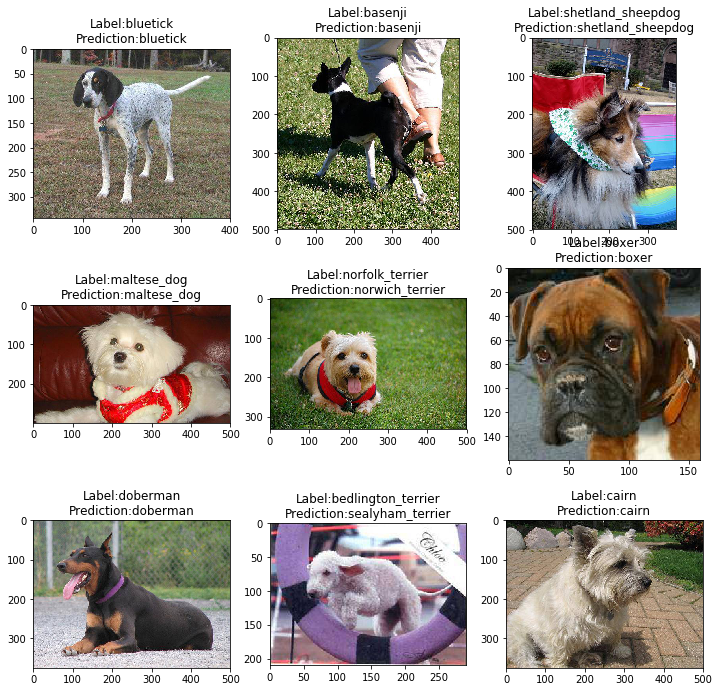

In [79]:
predicts(1)

#### Two ways to predict single image

In [65]:
trn_tfms,val_tfms = tfms_from_model(arch,sz,aug_tfms = transforms_side_on , max_zoom = 1.1)
# normally 1 object but now for the purpose of single prediction split into two
fn = data.val_ds.fnames[0]
im = trn_tfms(plt.imread(PATH/pic))

In [66]:
# 1st way
preds = learn.predict_array(im[None])
np.argmax(preds)

73

In [ ]:
# from dataset.py
def predict_array(self, arr):
        self.model.eval()
        return to_np(self.model(to_gpu(V(T(arr)))))

In [67]:
# 2nd way
im = T(im[None]).cuda()   # add one more dim, convert to tensor, put on cuda
preds = learn.model(V(im)) # convert to Variable, predict with learn.model()
preds = to_np(preds) # convert to np for argmax
np.argmax(preds)

73

### Predict on Test Set

In [18]:
log_preds, y = learn.TTA(is_test= True)

In [23]:
preds = np.mean(np.exp(log_preds), 0)

In [24]:
preds

array([[0.00057, 0.0001 , 0.0003 , ..., 0.00059, 0.00007, 0.00009],
       [0.     , 0.99546, 0.00001, ..., 0.     , 0.00005, 0.00001],
       [0.00333, 0.00004, 0.00032, ..., 0.00032, 0.00128, 0.00722],
       ...,
       [0.00001, 0.00001, 0.00001, ..., 0.     , 0.00002, 0.00001],
       [0.00051, 0.00009, 0.00004, ..., 0.00002, 0.00083, 0.04632],
       [0.00181, 0.00165, 0.00065, ..., 0.00013, 0.00015, 0.00009]], dtype=float32)

#### End